In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/ml/bin/python


In [2]:
import os
os.getcwd()

'/Users/vineet/Desktop/FoodVision-Mini'

In [ ]:
import os
import sys
from pathlib import Path
from timeit import default_timer as timer

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms, models

from tqdm.auto import tqdm
from PIL import Image
import requests

from torchinfo import summary

from src.data_setup import create_dataloaders
from src.engine import train_step, test_step
from src.utils import save_model
from src.predictions import pred_and_plot_image

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
from pathlib import Path

project_root = Path.cwd()

train_dir = project_root / "data" / "pizza_steak_sushi" / "train"
test_dir  = project_root / "data" / "pizza_steak_sushi" / "test"

train_dir, test_dir

(PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/train'),
 PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test'))

In [7]:
train_dir.exists(), test_dir.exists()

(True, True)

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.features[-1].parameters():
        param.requires_grad = True

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1,

In [ ]:
from src import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
from src import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device="mps")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7237 | train_acc: 0.7479 | test_loss: 0.2968 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.3409 | train_acc: 0.8979 | test_loss: 0.1807 | test_acc: 0.9659
Epoch: 3 | train_loss: 0.1930 | train_acc: 0.9396 | test_loss: 0.1637 | test_acc: 0.9659
Epoch: 4 | train_loss: 0.1825 | train_acc: 0.9479 | test_loss: 0.1366 | test_acc: 0.9750
Epoch: 5 | train_loss: 0.1147 | train_acc: 0.9750 | test_loss: 0.1257 | test_acc: 0.9563
Epoch: 6 | train_loss: 0.1416 | train_acc: 0.9542 | test_loss: 0.1292 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.0615 | train_acc: 0.9958 | test_loss: 0.1237 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.0852 | train_acc: 0.9542 | test_loss: 0.1366 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.1238 | train_acc: 0.9292 | test_loss: 0.0973 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.0785 | train_acc: 0.9917 | test_loss: 0.1117 | test_acc: 0.9625


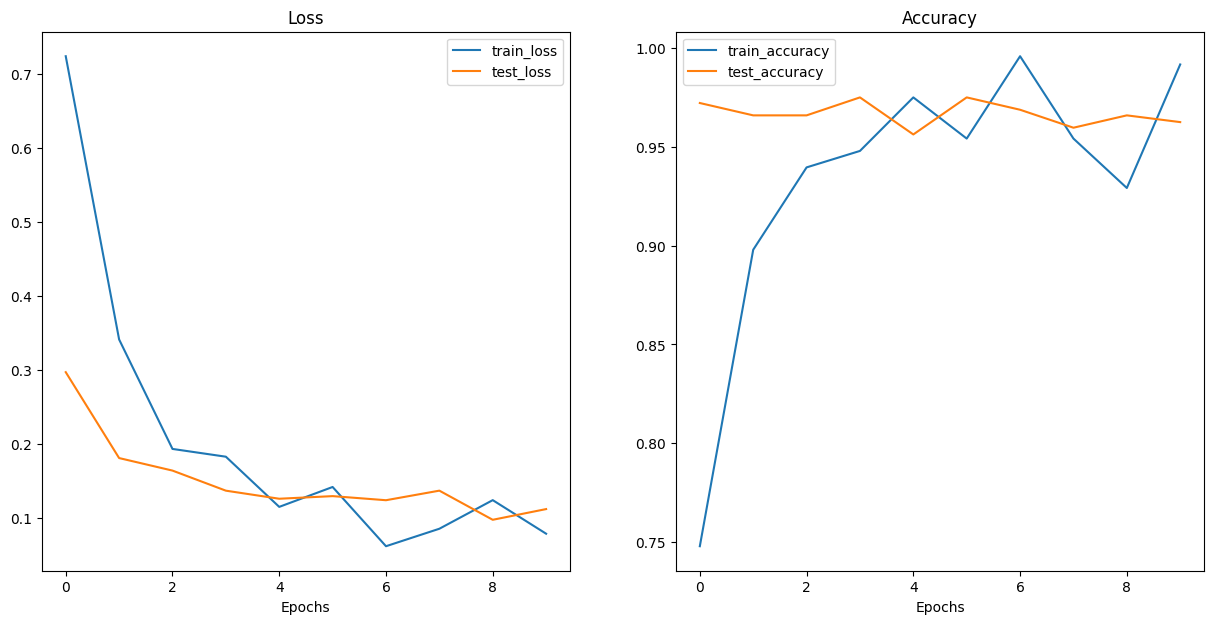

In [ ]:
from src import helper_functions

helper_functions.plot_loss_curves(effnetb2_results)

In [ ]:
from src import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [ ]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.11172788739204406,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [ ]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: /Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test


[PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/413497.jpg'),
 PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/2246332.jpg'),
 PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/2475366.jpg'),
 PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/1982192.jpg'),
 PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/2353677.jpg')]

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    pred_list = []

    for path in tqdm(paths):

        pred_dict = {}

        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)
        
        transformed_image = transform(img).unsqueeze(0).to(device)

        model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list

In [ ]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9959,
  'pred_class': 'steak',
  'time_for_pred': 0.3108,
  'correct': True},
 {'image_path': PosixPath('/Users/vineet/Desktop/FoodVision-Mini/data/pizza_steak_sushi/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9992,
  'pred_class': 'steak',
  'time_for_pred': 0.1447,
  'correct': True}]

In [ ]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/Users/vineet/Desktop/FoodVision-Mini/data/piz...,steak,0.9959,steak,0.3108,True
1,/Users/vineet/Desktop/FoodVision-Mini/data/piz...,steak,0.9992,steak,0.1447,True
2,/Users/vineet/Desktop/FoodVision-Mini/data/piz...,steak,0.9838,steak,0.1434,True
3,/Users/vineet/Desktop/FoodVision-Mini/data/piz...,steak,0.7135,steak,0.1425,True
4,/Users/vineet/Desktop/FoodVision-Mini/data/piz...,steak,0.8462,steak,0.1446,True


In [ ]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [ ]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1474 seconds


In [ ]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.11172788739204406,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.1474)}

## Gradio

In [45]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)

foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

In [46]:
!ls demos/foodvision_mini/

In [ ]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [
    Path("data/pizza_steak_sushi/test/sushi/example-sushi.jpg"),
    Path("data/pizza_steak_sushi/test/sushi/receita-de-sushi.jpg"),
    Path("data/pizza_steak_sushi/test/pizza/example-pizza.jpg")
]

for example in foodvision_mini_examples:
    if not example.exists():
        raise FileNotFoundError(f"{example} does not exist.")
        
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} → {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi/test/sushi/example-sushi.jpg → demos/foodvision_mini/examples/example-sushi.jpg
[INFO] Copying data/pizza_steak_sushi/test/sushi/receita-de-sushi.jpg → demos/foodvision_mini/examples/receita-de-sushi.jpg
[INFO] Copying data/pizza_steak_sushi/test/pizza/example-pizza.jpg → demos/foodvision_mini/examples/example-pizza.jpg


In [ ]:
import os

example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/.DS_Store'],
 ['examples/example-sushi.jpg'],
 ['examples/example-pizza.jpg'],
 ['examples/receita-de-sushi.jpg']]

In [ ]:
import shutil

effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos/foodvision_mini/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth: True


In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.features[-1].parameters():
        param.requires_grad = True
        
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Overwriting demos/foodvision_mini/model.py


In [ ]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ["pizza", "steak", "sushi"]

effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3,
)

effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),
    )
)

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)
    
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created by Vineet"

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demos/foodvision_mini/app.py


In [58]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.10.0
torchvision==0.25.0
gradio==5.50.0

Writing demos/foodvision_mini/requirements.txt


In [59]:
!ls demos/foodvision_mini

app.py
examples
model.py
pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
requirements.txt
